# <center><u><u>Bayesian Modeling for the Busy and the Confused - Part I</u></u></center>
## <center><i>Basic Principles of Bayesian Computation and the Grid Approximation</i><center>
Currently, the capacity to gather data is far ahead of the ability to generate meaningful insight using conventional approaches. Hopes of alleviating this bottleneck has come through the application of machine learning tools. Among these tools one that is increasingly garnering traction is probabilistic programming, particularly Bayesian modeling. In this paradigm, variables that are used to define models carry a probabilistic distribution rather than a scalar value. "Fitting" a model to data can then , simplistically, be construed as finding the appropriate parameterization for these distributions, given the model structure and the data. This offers a number of advantages over other methods, not the least of which is the estimation of uncertainty around model results. This in turn can better inform subsequent processes, such as decision-making, and/or scientific discovery.
<br><br>
<u>Part-I overview</u>:
The present is the first of a two-notebook series, the subject of which is a brief, basic, but hands-on programmatic introduction to Bayesian modeling. This first notebook begins with an overview of a few key probability principles relevant to Bayesian inference.  An illustration of how to put these in practice follows. In particular, I will demonstrate one of the more intuitve approaches to Bayesian computation; Grid Approximation (GA). With this framework I will show how to create simple models that can be used to interpret and predict real world data. <br>
<u>Part-II overview</u>:
GA is computationally intensive and runs into problems quickly when the data set is large and/or the model increases in complexity. One of the more popular solutions to this problem is the Markov Chain Monte-Carlo (MCMC) algorithm. The implementation of MCMC in Bayesian models will be the subject of the [second notebook of this series]().

<br>
<u>Hands-on approach with Python</u>:
Bayesian modeling cannot be understood without practice. To that end, this notebook uses code snippets that should be iteratively modified and run for better insight.
As of this writing the most popular programming language in machine learning is Python. Python is an easy language to pickup. Python is free, open source, and a large number of very useful libraries have been written over the years that have propelled it to its current place of prominence in a number of fields, in addition to machine learning.
<br><br>
I use Python (3.6+) code to illustrate the mechanics of Bayesian inference in lieu of lengthy explanations. I also use a number of dedicated Python libraries that shortens the code considerably. A solid understanding of Bayesian modeling cannot be spoon-fed and can only come from getting one's hands dirty.. Emphasis is therefore on readable reproducible code. This should ease the work the interested has to do to get some practice re-running the notebook  and experimenting with some of the coding and Bayesian modeling patterns presented. Some know-how is required regarding installing and running a Python distribution, the required libraries, and jupyter notebooks; this is easily gleaned from the internet. A popular option in the machine learning community is [Anaconda](https://www.anaconda.com/distribution).

<a id='TOP'></a>

## Notebook Contents


1. [Basics: Joint probability, Inverse probability and Bayes' Theorem](#BASIC)
2. [Example: Inferring the Statistical Distribution of Chlorophyll from Data](#JustCHL)
    1. [Grid Approximation](#GRID)
        1. [Impact of priors](#PriorImpact)
        2. [Impact of data set size](#DataImpact)
    2. [MCMC](#MCMC)
    3. [PyMC3](#PyMC3)
3. [Regression](#Reg)
    1. [Data Preparation](#DataPrep)
    2. [Regression in PyMC3](#RegPyMC3)
    3. [Checking Priors](#PriorCheck)
    4. [Model Fitting](#Mining)
    5. [Flavors of Uncertainty](#UNC)
4. [Final Comments](#Conclusion



In [2]:
import pickle
import warnings
import sys

import pandas as pd
import numpy as np
from scipy.stats import norm as gaussian, uniform

import seaborn as sb
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import ticker as mtick

In [ ]:
print('Versions:')
print('---------')
print(f'python:  {sys.version.split("|")[0]}')
print(f'numpy:   {np.__version__}')
print(f'pandas:  {pd.__version__}')
print(f'seaborn: {sb.__version__}')

In [ ]:
%matplotlib inline
warnings.filterwarnings('ignore',  category=FutureWarning)

<a id='BASIC'></a>
[Back to Contents](#TOP)

## 1. <u>Basics</u>:

#### $\Rightarrow$Joint probability, Inverse probability and Bayes'  rule
<br>
Here's a circumspect list of basic concepts that will help understand what is going on:

* Joint probability of two events $A$, $B$:
$$P(A, B)=P(A|B)\times P(B)=P(B|A)\times P(A)$$

* If A and B are independent: $$P(A|B) = P(A)\ \leftrightarrow P(A,B) = P(A)\times P(B)$$

* Inverse probability:$$\boxed{P(A|B) = \frac{P(B|A) \times P(A)}{P(B)}}$$ 

$\rightarrow$Inverse probability is handy when $P(A|B)$ is desired but hard to compute, but its counterpart, $P(B|A)$ is easy to compute. The result above which is derived directly from the joint probability formulation above, is referred to as Bayes' theorem/rule. One might ask next, how this is used to build a "Bayesian model."

#### $\Rightarrow$Extending Bayes' theorem to model building
<br>
Given a model:

* Hypotheses (\\(H\\)): values that model parameters can take
* \\( P(H) \\): probability of each value in H
* Data (\\( D \\))
* \\( P(D) \\): probability of the data, commonly referred to as "Evidence."

Approach 
* formulate initial opinion on what $H$ might include and with what probability, $P(H)$
* collect data ($D$) 
* update $P(H)$ using $D$ and Bayes' theorem

$$\frac{P(H)\times P(D|H)}{P(D)} = P(H|D)$$

Computing the "Evidence", P(D), can yield intractable integrals to solve. Fortunately, it turns out that we can approximate the posterior, and give those integrals a wide berth. Hereafter, P(D), will be considered a normalization constant and will therefore be dropped; without prejudice, as it turns out.<br><br>
$$\boxed{P(H) \times P(D|H) \propto P(H|D)}$$


Note that what we care about is updating H, model parameters, after evaluating some observations.
Let's go over each of the elements of this proportionality statement.

#### The prior
$$\underline{P(H)}\times P(D|H) \propto P(H|D)$$

* $H$: set of values that model parameters might take with corresponding probability $P(H)$.
* Priors should encompass justifiable assumptions/context information and nothing more.
* We can use probability distributions to express $P(H)$ as shown below.

#### The likelihood

$$P(H)\times \underline{P(D|H)} \propto  P(H|D)$$


* probability of the data, \\(D\\), *given* \\(H\\).
* in the frequentist framework, this quantity is maximized to find the "best" fit \\(\rightarrow\\) Likelihood Maximization.
    * maximizing the likelihood means finding a particular value for H, \\(\hat{H}\\).
    * for simple models and uninformative priors, \\(\hat{H}\\) often corresponds to the mode of the Bayesian posterior (see below).
    * likelihood maximization discards a lot of potentially valuable information (the posterior).

#### The posterior:

$$P(H)\times P(D|H) \propto \underline{P(H|D)}$$


* it's what Bayesians are after!!!
* updated probability of \\(H\\) after exposing the model to \\(D\\).
* used as prior for next iteration \\(P(H|D)\rightarrow P(H)\\), when new data become available.
* $P(H|D)$ naturally yields uncertainty around the estimate via propagation.


In the next section I will attempt to illustrate the mechanics of Bayesian inference on real-world data.

[Back to Contents](#TOP)

<a id='JustCHL'></a>
## 2. <u>Bayesian "Hello World": Inferring the Statistical Distribution of Chlorophyll</u>
<p>
   The goal of Bayesian modeling is to approximate the process that generated a set of outcomes observed. Often, a set of input observations can be used to modify the expected outcome via a deterministic model expression. In a first instance,  neither input observations nor deterministic expression are included. Only the set of outcomes is of concern here and the model is reduced to a probability assignment, using a simple statistical distribution. <br>
    For the present example the outcome of interest are some chlorophyll measurements. Assuming that the process generating these observations can be approximated, <u>after log-transformation of the data</u>, by a Gaussian distribution, the scalar parameters of which are not expected to vary. The goal is to the range of values these parameters - a constant central tendency, \\(\mu\\), and a constant spread \\(\sigma\\) - could take. Note that this example, while not realistic, is intended to help build intuition. Further down the road, the use of inputs and deterministic models will be introduced with linear regression as example.</p>

</p>   I will contrast two major approaches. <u>Grid computation</u>, and <u>Markov Chain Monte-Carlo</u>.  Note in both methods, , as mentioned earlier, the evidence \\(P(D)\\) is ignored. In both cases, relative probabilities are computed and subsequently normalized so as to add to 1.</p>

### A. Grid Computation

In grid-based inference, all the possible parameter combinations to infer upon are fixed before hand, through the building of a grid. This grid is made of as many dimensions as there are parameter to the model of interest. The user needs to define a range and a resolution for each dimension. This choice depends on the computing power available, and the requirements of the problem at hand.I will illustrate that as the model complexity increases, along with the number of parameters featured, the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) can quickly take hold and limit the usefulness of this approach.

Given a set of ranges and a resolutions for the grid's dimension, each grid point "stores" the joint probability of the corresponding parameter values. Initially the grid is populated by the stipulation of prior probabilities that should encode what is deemed to be "reasonable" by the practitioner. These priors can diverge between individual users. This is not a problem however as it makes assumptions - and therefore ground for disagreement - explicit and specific. As these priors are confronted to a relatively (usually to the model complexity) large amount of data, initially diverging priors tend to converge.

Given our model is a Gaussian distribution, our set of hypotheses (\\(H\\) in the previous section) includes 2 vectors; a mean \\(\mu\\) and a standard deviation \\(\sigma\\). The next couple of lines of code defines the corresponding two axes of a \\(200 \times 200\\) grid, and include the range of the axes, and by extension, their resolution. 

In [4]:
μ = np.linspace(-2, 2, num=200) # μ-axis
σ = np.linspace(0, 2, num=200) # σ-axis

For ease of manipulation I will use a [pandas DataFrame](), which at first sight looks deceivingly like a 'lame' spreadsheet, to store the grid coordinates. I use this dataframe to subsequently store the prior definitions, and the results of likelihood and posterior computation at each grid point. Here's the code that defines the DataFrame, named and populates the first two columns \\(\mu\\) and \\(\sigma\\).

In [5]:
df_grid = pd.DataFrame([[μ_i, σ_i]
                        for σ_i in σ for μ_i in μ], columns=['μ', 'σ'])

Accessing say the column **\\(\mu\\)** is as simple as typing: ***df\_grid.\\(\mu\\)***
#### Priors

The next step is to define the priors for both **\\(\mu\\)** and **\\(\sigma\\)** that encodes what the user's knowledge, or more commonly her or his lack thereof. Principles guiding the choice of priors are beyond the scope of this post. For no other reason than what seems to make sense. In this case, chlorophyll is expected to be log-transformed, so \\(\mu\\) should range within a few digits north and south of '0', and \\(\sigma\\) should be positive, and not expected to range beyond a few orders of magnitude. Thus a normal distribution for \\(\mu\\) and a uniform distribution for \\(\sigma\\) parameterized as below seems to make sense: <br>
\\(\rightarrow \mu \sim \mathcal{N}(mean=1, st.dev.=1)\\); a gaussian (normal) distribution centered at 1, with an standard deviation of 1<br>
\\(\rightarrow \sigma \sim \mathcal{U}(lo=0, high=2)\\); a uniform distribution bounded at 0 and 2<br>

Note that these are specified independently because \\(\mu\\) and \\(\sigma\\) are assumed independent.
The code below computes the probability for each \\(\mu\\) and \\(\sigma\\) values;

The lines below show how to pass the grid defined above to the scipy.stats distribution functions to compute the prior at each grid point.

In [7]:
μ_log_prior = gaussian.logpdf(df_grid.μ, 1, 1)
σ_log_prior = uniform.logpdf(df_grid.σ, 0, 2)

Note that the code above computes the log (prior) probability of each parameter at each grid point. Because the parameters \\(\mu\\) and \\(\sigma\\) are assumed independent, the joint prior probability at each grid point is just the product the individual prior probability. Products of probabilities can result in underflow errors. Log-transformed probabilities can be summed and exponentiated to compute joint probabilities of the entire grid can be computed by summing log probabilities followed by taking the exponent of the result. I store both the joint log-probability and the log-probability at each grid point in the pandas dataframe with the code snippet below:

In [8]:
# log prior probability
df_grid['log_prior_prob'] = μ_log_prior + σ_log_prior
# straight prior probability from exponentiation of log_prior_prob
df_grid['prior_prob'] = np.exp(df_grid.log_prior_prob
                                - df_grid.log_prior_prob.max())

Since there are only two parameters, visualizing the joint prior probability is straighforward:

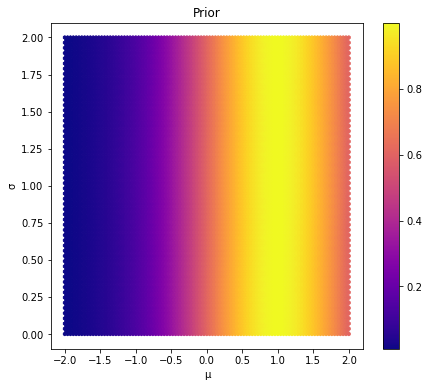

In [11]:
f, ax = pl.subplots(figsize=(6, 6))
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob', figsize=(7,6),
                    cmap='plasma', sharex=False, ax=ax);
ax.set_title('Prior')
f.savefig('./resources/f1_grid_prior.svg')

In the figure above looking across the \\(\sigma\\)-axis reveals the 'wall' of uniform probability where none of the positive values, bounded here between 0 and 2.0, is expected to be more likely. Looking down the \\(\mu\\)-axis, on the other hand, reveals the gaussian peak around 1, within a grid of floats extending from -2.0 to 2.0. 
Once priors have been defined, the model is ready to be fed some data. The *chl_* loaded earlier had several thousand observations. Because grid approximation is computationally intensive, I'll only pick a handful of data. For reasons discussed further below, this will enable the comparison of the effects different priors can have on the final result.
I'll start by selecting 10 observations. 

<a id='GRID'></a>
#### Building the Grid

For this example I simply want to approximate the distribution of *chl_l* following these steps: 

* Define a model to approximate the process that generates the observations
    * Theory: data generation is well approximated by a Gaussian.
    * Hypotheses (\\(H\\)) therefore include 2 vectors; mean \\(\mu\\) and standard deviation \\(\sigma\\).
    * Both parameters are expected to vary within a certain range.
* Build the grid of model parameters
    * 2D grid of \\((\mu, \sigma)\\) pair
* Propose priors
    * define priors for both \\(\mu\\) and \\(\sigma\\)
* Compute likelihood
* Compute posterior

First, I load data stored in a pandas dataframe that contains among other things, log-transformed phytoplankton chlorophyll (*chl_l*) values measured during oceanographic cruises around the world.

In [ ]:
df_data = pd.read_pickle('./pickleJar/df_logMxBlues.pkl')

In [ ]:
df_data[['MxBl-Gr', 'chl_l']].info()

here are two columns. *MxBl-Gr* is a blue-to-green ratio that will serve as predictor of chlorophyll when I address regression. For now, *MxBl-Gr* is ignored, only *chl_l* is of interest. Here is what the distribution of *chl_l*, smoothed by kernel density estimation, looks like:

In [ ]:
f, ax = pl.subplots(figsize=(4,4))
sb.kdeplot(df_data.chl_l, ax=ax, legend=False);
ax.set_xlabel('chl_l');
f.tight_layout()
f.savefig('./figJar/Presentation/fig1_chl.svg', dpi=300, format='svg')

... and here is what it looks like.

In [ ]:
print(df_grid.shape)
df_grid.head(7)

In the figure above looking down the \\(\sigma\\)-axis shows the 'wall' of uniform probability where none of the positive values, capped here at 2.0 has is expected to be more likely. Looking down the \\(\mu\\)-axis, on the other hand, reveals the gaussian peak around 1, within a grid of floats extending from -2.0 to 2.0. 
Once priors have been defined, the model is ready to be fed some data. The *chl_* loaded earlier had several thousand observations. Because grid approximation is computationally intensive, I'll only pick a handful of data. For reasons discussed further below, this will enable the comparison of the effects different priors can have on the final result.
I'll start by selecting 10 observations. 

In [ ]:
sample_N = 10
df_data_s = df_data.dropna().sample(n=sample_N)

In [ ]:
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

Compute Log-Likelihood of the data given every  pair \\( ( \mu ,\sigma)\\). This is done by summing the log-probability of each datapoint, given each grid point; i.e. each \\((\mu, \sigma)\\) pair.

In [ ]:
df_grid['LL'] = np.sum(norm.logpdf(df_data_s.chl_l.values.reshape(1, -1),
                                    loc=df_grid.μ.values.reshape(-1, 1),
                                    scale=df_grid.σ.values.reshape(-1, 1)
                                   ), axis=1)

#### Compute Posterior $P(\mu,\sigma\ | data) \propto P(data | \mu, \sigma) \times P(\mu, \sigma)$

In [ ]:
# compute log-probability
df_grid['log_post_prob'] = df_grid.LL + df_grid.log_prior_prob
# convert to straight prob.
df_grid['post_prob'] = np.exp(df_grid.log_post_prob
                               - df_grid.log_post_prob.max())

In [ ]:
# Plot Multi-Dimensional Prior and Posterior
f, ax = pl.subplots(ncols=2, figsize=(12, 5), sharey=True)
df_grid.plot.hexbin(x='μ', y='σ', C='prior_prob',
                    cmap='plasma', sharex=False, ax=ax[0])
df_grid.plot.hexbin(x='μ', y='σ', C='post_prob',
                     cmap='plasma', sharex=False, ax=ax[1]);
ax[0].set_title('Prior Probability Distribution')
ax[1].set_title('Posterior Probability Distribution')
f.tight_layout()
f.savefig('./figJar/Presentation/grid1.svg')

<img src='./resources/grid1.svg'/>

In [ ]:
# Compute Marginal Priors and Posteriors for each Parameter
df_μ = df_grid.groupby(['μ']).sum().drop('σ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index()
df_σ = df_grid.groupby(['σ']).sum().drop('μ', axis=1)[['prior_prob',
                                                        'post_prob']
                                                      ].reset_index() 

# Normalize Probability Distributions
df_μ.prior_prob /= df_μ.prior_prob.max()
df_μ.post_prob /= df_μ.post_prob.max()
df_σ.prior_prob /= df_σ.prior_prob.max()
df_σ.post_prob /= df_σ.post_prob.max()

In [ ]:
#Plot Marginal Priors and Posteriors
f, ax = pl.subplots(ncols=2, figsize=(12, 4))
df_μ.plot(x='μ', y='prior_prob', ax=ax[0], label='prior');
df_μ.plot(x='μ', y='post_prob', ax=ax[0], label='posterior')
df_σ.plot(x='σ', y='prior_prob', ax=ax[1], label='prior')
df_σ.plot(x='σ', y='post_prob', ax=ax[1], label='posterior');
f.suptitle('Marginal Probability Distributions', fontsize=16);
f.tight_layout(pad=2)
f.savefig('./figJar/Presentation/grid2.svg')

[Back to Contents](#TOP)
<a id='PriorImpact'></a>

### Impact of Priors

In [ ]:
def compute_bayes_framework(data, priors_dict):
    # build grid:
    μ = np.linspace(-2, 2, num=200)
    σ = np.linspace(0, 2, num=200)
    df_b = pd.DataFrame([[μ_i, σ_i] for σ_i in σ for μ_i in μ],
                        columns=['μ', 'σ'])
    # compute/store distributions
    μ_prior = norm.logpdf(df_b.μ, priors_dict['μ_mean'],
                          priors_dict['μ_sd'])
    σ_prior = uniform.logpdf(df_b.σ, priors_dict['σ_lo'],
                             priors_dict['σ_hi'])
    # compute joint prior
    df_b['log_prior_prob'] = μ_prior + σ_prior 
    df_b['prior_prob'] = np.exp(df_b.log_prior_prob
                                    - df_b.log_prior_prob.max())
    # compute log likelihood
    df_b['LL'] = np.sum(norm.logpdf(data.chl_l.values.reshape(1, -1),
                                    loc=df_b.μ.values.reshape(-1, 1),
                                    scale=df_b.σ.values.reshape(-1, 1)
                                   ), axis=1)
    # compute joint posterior
    df_b['log_post_prob'] = df_b.LL + df_b.log_prior_prob
    df_b['post_prob'] = np.exp(df_b.log_post_prob
                               - df_b.log_post_prob.max())
    return df_b


def plot_posterior(df_, ax1, ax2):
    df_.plot.hexbin(x='μ', y='σ', C='prior_prob',
                        cmap='plasma', sharex=False, ax=ax1)
    df_.plot.hexbin(x='μ', y='σ', C='post_prob',
                         cmap='plasma', sharex=False, ax=ax2);
    ax1.set_title('Prior Probability Distribution')
    ax2.set_title('Posterior Probability Distribution')
    
    
def plot_marginals(df_, ax1, ax2, plot_prior=True):
    """Compute marginal posterior distributions."""
    df_μ = df_.groupby(['μ']).sum().drop('σ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index()
    df_σ = df_.groupby(['σ']).sum().drop('μ',
                                         axis=1)[['prior_prob',
                                                  'post_prob']
                                                ].reset_index() 
    
    # Normalize Probability Distributions
    df_μ.prior_prob /= df_μ.prior_prob.max()
    df_μ.post_prob /= df_μ.post_prob.max()
    df_σ.prior_prob /= df_σ.prior_prob.max()
    df_σ.post_prob /= df_σ.post_prob.max()

    #Plot Marginal Priors and Posteriors
    if plot_prior:
        df_μ.plot(x='μ', y='prior_prob', ax=ax1, label='prior');
        df_σ.plot(x='σ', y='prior_prob', ax=ax2, label='prior')
    df_μ.plot(x='μ', y='post_prob', ax=ax1, label='posterior')
    df_σ.plot(x='σ', y='post_prob', ax=ax2, label='posterior');

Try two priors:
1. $\mu \sim \mathcal{N}(1, 1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a weakly informative set of priors

In [ ]:
weak_prior=dict(μ_mean=1, μ_sd=1, σ_lo=0, σ_hi=2)
df_grid_1 = compute_bayes_framework(df_data_s, priors_dict=weak_prior)

In [ ]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_1, axp[0], axp[1])
plot_marginals(df_grid_1, axp[2], axp[3])
axp[2].legend(['weak prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid3.svg')

<img src="./resources/grid3.svg?modified=3"/>

2. $\mu \sim \mathcal{N}(-1.5, 0.1)$, $\sigma \sim \mathcal{U}(0, 2)$ - a strongly informative prior

In [ ]:
strong_prior=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
df_grid_2 = compute_bayes_framework(df_data_s, priors_dict=strong_prior)

In [ ]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_2, axp[0], axp[1])
plot_marginals(df_grid_2, axp[2], axp[3])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid4.svg')

[Back to Contents](#TOP)
<a id='DataImpact'></a>

### Impact of data set size
* sub-sample size is now 500 samples,
* same two priors used

In [ ]:
sample_N = 500

# compute the inference dataframe
df_data_s = df_data.dropna().sample(n=sample_N)

In [ ]:
# display the new sub-sample
g = sb.PairGrid(df_data_s.loc[:,['MxBl-Gr', 'chl_l']],
                diag_sharey=False)
g.map_diag(sb.kdeplot, )
g.map_offdiag(sb.scatterplot, alpha=0.75, edgecolor='k');
make_lower_triangle(g)
g.axes[1,0].set_ylabel(r'$log_{10}(chl)$');
g.axes[1,1].set_xlabel(r'$log_{10}(chl)$');

In [ ]:
%%time
df_grid_3 = compute_bayes_framework(df_data_s, priors_dict=weak_prior)

In [ ]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_3, axp[2], axp[3])
axp[2].legend(['weak prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid5.svg')

<img src=./resources/grid5.svg/>

In [ ]:
df_grid_4 = compute_bayes_framework(df_data_s, priors_dict=strong_prior)

In [ ]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 9))
axp = axp.ravel()
plot_posterior(df_grid_4, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid6.svg')

<img src=./resources/grid6.svg/>

In [ ]:
f , axp = pl.subplots(ncols=2, nrows=2, figsize=(12, 8), sharey=True)
axp = axp.ravel()
plot_marginals(df_grid_3, axp[0], axp[1])
plot_marginals(df_grid_4, axp[2], axp[3])
axp[0].legend(['weak prior', 'posterior'])
axp[1].legend(['flat prior', 'posterior'])
axp[2].legend(['strong prior', 'posterior'])
axp[3].legend(['flat prior', 'posterior'])
f.tight_layout()
f.savefig('./figJar/Presentation/grid7.svg')

***And using all the data?***

In [ ]:
%%time
priors=dict(μ_mean=-1.5, μ_sd=.1, σ_lo=0, σ_hi=2)
try:
    df_grid_all_data= compute_bayes_framework(df_data, priors_dict=priors)
except MemoryError:
    print("OUT OF MEMORY!")
    print("--------------")

[Back to Contents](#TOP)
<a id="Next"></a>